In [1]:
import torch
from datasets import Dataset
import json
from tabulate import tabulate
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from peft import LoraConfig, get_peft_model

/home/tobias/ui-rl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
with open("../runs/20251102_191524/rollout_004.json") as f:
    rollout = json.load(f)

# Preprocess
for message in rollout["messages"]:
    # Convert "content" to list if str
    if type(message["content"]) == str:
        message["content"] = [{"type": "text", "text": message["content"]}]
    # Remove all keys except "content" or "role"
    keys_to_remove = [k for k in list(message.keys()) if k not in ("role", "content")]
    for k in keys_to_remove:
        del message[k]
    # Convert "image_url" -> "image"
    for block in message["content"]:
        if block["type"] == "image_url":
            block["type"] = "image"
            block["image"] = block["image_url"]["url"]
            del block["image_url"]

In [29]:
from collections import Counter

def get_completions(rollout):
    completion_indices = Counter()
    for i, completion in enumerate(rollout["completions"]):
        longest = i
        for j, completion_cand in enumerate(rollout["completions"]):
            if completion_cand["context"][:len(completion["context"])+1] == completion["context"] + [completion["completion"]]:
                if len(completion_cand["context"]) > len(rollout["completions"][longest]["context"]):
                    longest = j
        completion_indices[longest] += 1
    print(completion_indices)
    completions = [(rollout["completions"][i], count) for i, count in completion_indices.items()]
    output = []
    for completion, count in completions:
        messages = [rollout["messages"][i] for i in completion["context"]] + [rollout["messages"][completion["completion"]]]
        output.append((messages, count))
    return output

completions = get_completions(rollout)

Counter({9: 10, 10: 1, 11: 1, 12: 1, 13: 1})


In [2]:
processor = AutoProcessor.from_pretrained("ByteDance-Seed/UI-TARS-1.5-7B")

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


In [37]:
def find_assistant_spans(input_ids: list):
    def find_all_sublists(lst, sub):
        n, m = len(lst), len(sub)
        def find_end(start):
            for i in range(start+1, len(lst)):
                if lst[i] == messages_end_id:
                    return i
            else:
                return -1
        return [(i+len(sub), find_end(i)) for i in range(n - m + 1) if lst[i:i+m] == sub]
    assistant_message_start_seq = [151644, 77091, 198]
    messages_end_id = 151645
    return find_all_sublists(input_ids, assistant_message_start_seq)

def preprocess(row):
    def remove_none_values(obj):
        if isinstance(obj, dict):
            keys_to_delete = [k for k, v in obj.items() if v is None]
            for k in keys_to_delete:
                del obj[k]
            for v in obj.values():
                remove_none_values(v)
        elif isinstance(obj, list):
            for item in obj:
                remove_none_values(item)
    remove_none_values(row["messages"])

    inputs = processor.apply_chat_template(
        row["messages"],
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    )
    labels = torch.zeros_like(inputs["input_ids"]).fill_(-100)
    spans = find_assistant_spans(inputs["input_ids"][0].tolist())[-row["num_completions"]:]
    for start_idx, end_idx in spans:
        assert end_idx != -1, "Couldn'f find end of assistant message"
        labels[0, start_idx:end_idx+1] = inputs["input_ids"][0, start_idx:end_idx+1]

    row["input_ids"] = inputs["input_ids"]
    row["attention_mask"] = inputs["attention_mask"]
    row["pixel_values"] = inputs["pixel_values"]
    row["image_grid_thw"] = inputs["image_grid_thw"]
    row["labels"] = labels
    row["spans"] = spans
    return row

rows = [{"messages": completion, "num_completions": num_completions} for completion, num_completions in get_completions(rollout)]
ds = Dataset.from_list(rows)
ds = ds.map(preprocess)
ds.set_format(type="torch")

Counter({9: 10, 10: 1, 11: 1, 12: 1, 13: 1})


Map: 100%|██████████| 5/5 [00:10<00:00,  2.09s/ examples]


In [38]:
ds

Dataset({
    features: ['messages', 'num_completions', 'input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw', 'labels', 'spans'],
    num_rows: 5
})

In [17]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "ByteDance-Seed/UI-TARS-1.5-7B", 
    device_map="cuda", 
    dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
)
model.config.use_cache = False
model.gradient_checkpointing_enable()

Loading checkpoint shards: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


In [18]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [19]:
model = model.train()
#model.eval()

In [40]:
inputs = ds[0]
inputs = {k: v.to("cuda") for k, v in inputs.items() if isinstance(v, torch.Tensor)}

output = model(reduction="none", **inputs)

/home/tobias/ui-rl/.venv/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [44]:
completion_idx = 9

ref_tokens = [ref_token['token'] for ref_token in rollout["completions"][completion_idx]["logprobs"]]
ref_logprobs = [ref_token['logprob'] for ref_token in rollout["completions"][completion_idx]["logprobs"]]

span = inputs["spans"][9] #find_assistant_spans(inputs["input_ids"][0].tolist())[1]

completion_tokens = inputs["input_ids"][0][span[0]:span[1]+1]
completion_loss = output.loss[span[0]-1:span[1]]

data = [
    (token_id, processor.tokenizer.decode([token_id]).__repr__(), ref_token.__repr__(), -ref_logprob, loss, loss+ref_logprob)
    for token_id, ref_token, ref_logprob, loss in zip(completion_tokens, ref_tokens, ref_logprobs, completion_loss)
]

print(tabulate(data, headers=["Token ID", "Decoded token", "Ref token", "Ref neg logprob", "loss", "Diff"]))

  Token ID  Decoded token    Ref token         Ref neg logprob          loss          Diff
----------  ---------------  --------------  -----------------  ------------  ------------
     84169  'Thought'        'Thought'            -0            -0             0
        25  ':'              ':'                   1.78814e-06   2.02656e-06   2.38418e-07
       358  ' I'             ' I'                  0.991726      0.987035     -0.00469089
      3003  "'ve"            "'ve"                 1.56716       1.57379       0.00663102
      4091  ' selected'      ' selected'           1.85312       1.87882       0.0257061
       279  ' the'           ' the'                0.470491      0.511857      0.0413659
      2551  ' email'         ' email'              0.705003      0.762488      0.0574847
      2621  ' address'       ' address'            0.516036      0.543583      0.0275477
       330  ' "'             ' "'                  0.900811      0.80013      -0.100681
        89  'z'       

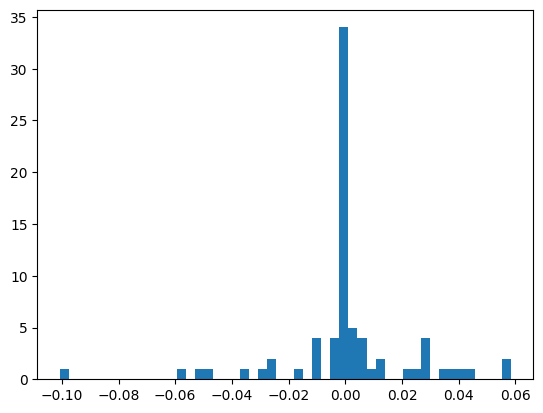

In [45]:
import matplotlib.pyplot as plt
import numpy as np

ref_neg_logprobs = -np.array(ref_logprobs)
completion_loss_np = completion_loss.cpu().detach().numpy()

#print(completion_loss_np)

_ = plt.hist(completion_loss_np-ref_neg_logprobs, bins=50)

In [12]:
print(tabulate([(processor.tokenizer.decode([token_id]).__repr__(), token_id) for token_id in inputs.input_ids[0].tolist()]))


------------------  ------
'<|im_start|>'      151644
'system'              8948
'\n'                   198
'You'                 2610
' are'                 525
' a'                   264
' helpful'           10950
' assistant'         17847
'.'                     13
'<|im_end|>'        151645
'\n'                   198
'<|im_start|>'      151644
'user'                 872
'\n'                   198
'You'                 2610
' are'                 525
' a'                   264
' GUI'               16435
' agent'              8315
'.'                     13
' You'                1446
' are'                 525
' given'              2661
' a'                   264
' task'               3383
' and'                 323
' your'                697
' action'             1917
' history'            3840
','                     11
' with'                448
' screenshots'       48720
'.'                     13
' You'                1446
' need'               1184
' to'                  311
'

In [20]:
output.loss.backward()

In [21]:
model.print_trainable_parameters()

trainable params: 5,046,272 || all params: 8,297,212,928 || trainable%: 0.0608


In [22]:
import torch
import gc

def get_gpu_tensors_sorted_by_size(device_id=0):
    """
    Retrieves all PyTorch tensors currently in GPU memory, calculates their size,
    and returns a sorted list of their properties.
    """
    print(f"--- Listing Live PyTorch Tensors on GPU {device_id} ---")
    
    tensor_info = []
    
    # 1. Iterate through all objects tracked by the Python garbage collector
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda and obj.get_device() == device_id:
                # Calculate size in bytes: element_size * number_of_elements
                size_in_bytes = obj.element_size() * obj.nelement()
                
                tensor_info.append({
                    'size_MB': size_in_bytes / (1024 * 1024),
                    'shape': tuple(obj.size()),
                    'dtype': obj.dtype,
                    'requires_grad': obj.requires_grad,
                    # Optional: Add traceback/origin for more advanced debugging if needed
                })
        except Exception:
            # Safely skip objects that raise an error during property check
            continue

    # 2. Sort the list by size in descending order
    tensor_info.sort(key=lambda x: x['size_MB'], reverse=True)
    
    # 3. Print the sorted list
    print(f"Total Tensors Found: {len(tensor_info)}")
    print("-----------------------------------------------------------------------")
    print(f"{'Size (MB)':<12} {'Shape':<30} {'Dtype':<12} {'Grad':<5}")
    print("-----------------------------------------------------------------------")
    for info in tensor_info[:100]: # Only list the top 20 largest tensors
        size_str = f"{info['size_MB']:<11.3f}"
        shape_str = f"{str(info['shape']):<30}"
        dtype_str = f"{str(info['dtype']).split('.')[-1]:<12}"
        grad_str = f"{str(info['requires_grad']):<5}"
        print(f"{size_str} {shape_str} {dtype_str} {grad_str}")
    
    print("-----------------------------------------------------------------------")

    # Calculate total size in MB of all tensors
    total_size_mb = sum(info['size_MB'] for info in tensor_info)
    print(f"Total size of all tensors: {total_size_mb:.3f} MB")


    return tensor_info

# Example Usage:
# Run this function at the point of your crash (or near it)
_ = get_gpu_tensors_sorted_by_size(device_id=0)

--- Listing Live PyTorch Tensors on GPU 0 ---
Total Tensors Found: 1230
-----------------------------------------------------------------------
Size (MB)    Shape                          Dtype        Grad 
-----------------------------------------------------------------------
1367.534    (1, 4715, 152064)              bfloat16     True 
1039.500    (152064, 3584)                 bfloat16     False
1039.500    (152064, 3584)                 bfloat16     False
129.500     (18944, 3584)                  bfloat16     False
129.500     (18944, 3584)                  bfloat16     False
129.500     (3584, 18944)                  bfloat16     False
129.500     (18944, 3584)                  bfloat16     False
129.500     (18944, 3584)                  bfloat16     False
129.500     (3584, 18944)                  bfloat16     False
129.500     (18944, 3584)                  bfloat16     False
129.500     (18944, 3584)                  bfloat16     False
129.500     (3584, 18944)              

/home/tobias/ui-rl/.venv/lib/python3.12/site-packages/torch/__init__.py:1125: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
